# Reinforcement Learning:Assignment 3
In this assignment we will learn how to implement the On-policy Sarsa and off-policy Q-learning algorithms.

## Grid World Environement

The environement is a grid where the agent can go from one case to the next.

**Description**:
- **States:** the different position on the grid. `S` indicates the start state and `G` indicates the final state.
- **Actions:** up (`0`), right (`1`), down (`2`), and left (`3`).
- **Rewards:** `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise.
- **Discount factor:** $\gamma = 0.9$

We will use the environement called: `Grid`

In [45]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn-notebook')
# plt.style.use('seaborn-whitegrid')

class Action(Enum):
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3

class Grid():
  def __init__(self, discount=0.9, penalty_for_walls=-5):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0, -1,  0,  0, -1],
      [-1,  0,  0,  0, -1,  0,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._layout_dims = self._layout.shape
    self._name = 'Grid'

  @property
  def number_of_states(self):
      return self._number_of_states

  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout <= -1, interpolation="nearest")
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title(self._name)
    plt.text(
        self._start_state[0], self._start_state[1],
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1],
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action: Action):
    y, x = self._state

    if action == Action.UP:  # up
      new_state = (y - 1, x)
    elif action == Action.RIGHT:  # right
      new_state = (y, x + 1)
    elif action == Action.DOWN:  # down
      new_state = (y + 1, x)
    elif action == Action.LEFT:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {}".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state

    self._state = new_state
    return reward, discount, self.get_obs()

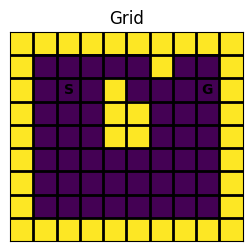

In [46]:
grid = Grid()
grid.plot_grid()

In [47]:
# Simple interaction loop with the MDP:
# 1) Interact with the environment
# 2) Agent gets observation, rewards, and discount from env.
# and is expected to produce the next action
def run_experiment(env, agent, number_of_steps, epsilon):
    
    mean_reward = 0.
    action = agent.initialAction()
    # Interaction wih the MDP
    for i in range(number_of_steps):

      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state, epsilon)

      mean_reward += (reward - mean_reward)/(i + 1.)
    
      

    return mean_reward

In [48]:
# Functions to use for Visualization
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a.value]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

# Visualising the e-greedy value function V^{\mu}
def plot_state_value(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$d(s)$")

# Visualising all value functions, for all actions
def plot_action_values(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in list(Action):
    plt.subplot(3, 3, map_from_action_to_subplot(a))

    plot_values(q[..., a.value], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = a.name
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")

  plt.subplot(3, 3, 5)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)

def plot_stats(stats, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(stats.episode_lengths), window)
  plt.plot(xline, smooth(stats.episode_lengths, window=window))
  plt.ylabel('Episode Length')
  plt.xlabel('Episode Count')
  plt.subplot(122)
  plt.plot(xline, smooth(stats.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

def plot_policy(grid, policy):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  grid.plot_grid()
  plt.title('Policy Visualization')
  for i in range(9):
    for j in range(10):
      action_name = action_names[policy[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def visualise_policy(grid, agent):
  pi = np.zeros(grid._layout_dims, dtype=np.int32)
  for i in range(grid._layout_dims[0]):
    for j in range(grid._layout_dims[1]):
      state = i*grid._layout.shape[1] + j
      pi[i, j] = agent.greedy_policy_step(state, epsilon=0.).value
  plot_policy(grid, pi)

### Exercise I: Implementing the Sarsa algorithm

**Description of Sarsa Algorithm (On-policy control for estimating $Q \approx q^*$):**

**Algorithm parameters**: step size $\alpha \in (0, 1]$, small $\epsilon > 0$

- Initialize $Q(s,a)$ arbitrarily except that $Q(terminal,\cdot\;) = 0$

- Loop for each episode:

    - Initialize $S$

    - Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
  
    - Loop for each step of episode:

        1. Take action $A$, observe $R$, $S^\prime$
        2. Choose $A^\prime$ from $S^\prime$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
        3. $Q(S, A)  = Q(S, A) + \alpha * (R + \gamma Q(S^\prime, A^\prime) - Q(S, A))$
        4. $S = S^\prime$, $A = A^\prime$ until S is terminal

In [49]:
class SarsaAgent():
  def __init__(
      self, number_of_states, actions, initial_state,
      step_size=0.1, epsilon=0.1):
    self._state = initial_state
    self._number_of_states = number_of_states
    self._step_size = step_size
    self._actions = actions
    self._action = self.initialAction()
    self._epsilon = epsilon

    # number of actions
    self._total_actions = len(actions)
    # initialize your q-values (this is a table indexed by state and action pairs)
    self._q = np.zeros((number_of_states, self._total_actions)) # ToDo: Write your code here
    #print("q value: ", self._q)

  @property
  def q_values(self):
    return self._q

  def initialAction(self):
    return self._actions(0)


  def greedy_policy_step(self, state, epsilon):
    # make epsilon-greedy policy step and return an action
    # Write you code here
    #ToDo
    if np.random.rand() < epsilon:
      # choose an action randomly from the list of actions
      action = np.random.choice(list(self._actions))
    else:
      # action is the current best action
      action = self._actions(np.argmax(self._q[state]))
    #print(" greedy action: ", action)
    return action


  def step(self, reward, discount, next_state, epsilon):
    s = self._state
    a = self._action
    self._state = next_state

        # update Sarsa
        # choose the next action action
    next_action = self.greedy_policy_step(next_state, epsilon)

    # Sarsa rule for updating
    # Q(S,A) = Q(S,A) + step_size * (R + disount(Next_state) - current_state))
    self._q[s][a.value] = self._q[s][a.value] + self._step_size * (reward + discount * self._q[next_state][next_action.value] - self._q[s][a.value])


    self._action = next_action

    
    return self._action
  


### Testing your solution

AFTER 100000 STEPS ...


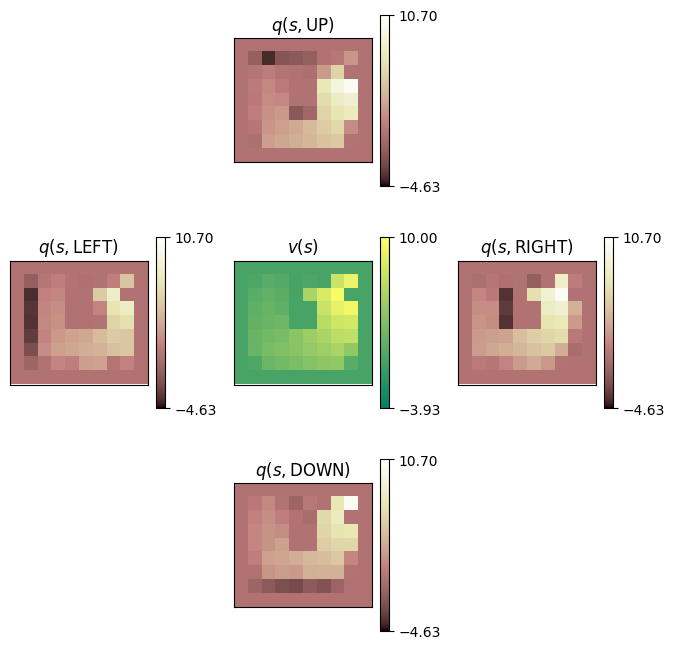

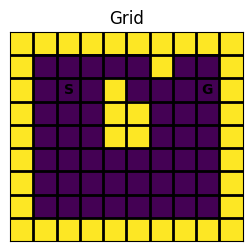

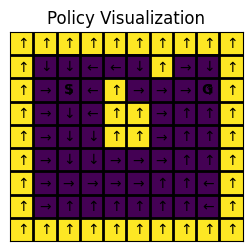

In [50]:
num_steps = 100000
epsilon=0.2

# environment
grid = Grid()

# agent
agent = SarsaAgent(
    number_of_states=grid._layout.size,
    actions=Action,
    initial_state=grid.get_obs(),
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps, epsilon)

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=epsilon)
grid.plot_grid()
visualise_policy(grid, agent)

### Exercise II: Implementing the Q-learning algorithm

**Description of Q-learning Algorithm (Off-policy control for estimating $Q \approx q^*$):**

**Algorithm parameters**: step size $\alpha \in (0, 1]$, small $\epsilon > 0$

- Initialize $Q(s,a)$ arbitrarily except that $Q(terminal,\cdot\;) = 0$

- Loop for each episode:

    - Initialize $S$
  
    - Loop for each step of episode:

        1. Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
        2. Take action $A$, observe $R$, $S^\prime$.
        3. $Q(S, A)  = Q(S, A) + \alpha * (R + \gamma \underset{a}{\rm max}Q(S^\prime, A^\prime) - Q(S, A))$
        4. $S = S^\prime$, $A = A^\prime$ until S is terminal

In [51]:
class QLearningAgent(object):

  def __init__(
      self, number_of_states, actions, initial_state,
      step_size=0.1):
    self._state = initial_state
    self._number_of_states = number_of_states
    self._step_size = step_size
    self._actions = actions
    self._action = self.initialAction()

    # number of actions
    self._total_actions = len(actions)
    # initialize your q-values (this is a table indexed by state and action pairs)
    self._q = np.zeros((number_of_states, self._total_actions)) # ToDo: Write your code here


  @property
  def q_values(self):
    return self._q

  def initialAction(self):
    return self._actions(0)


  
  def greedy_policy_step(self, state, epsilon):
    # make epsilon-greedy policy step and return an action
    # Write you code here
    #ToDo
    if np.random.rand() < epsilon:
      # choose an action randomly from the list of actions
      action = np.random.choice(list(self._actions))
    else:
      # action is the current best action
      action = self._actions(np.argmax(self._q[state]))
  
    return action

  def step(self, reward, discount, next_state, epsilon):
    s = self._state
    a = self._action
    self._state = next_state
    #ToDo

    # choose action A from S using the e-greedy policy
    next_action = self.greedy_policy_step(next_state, epsilon)
    # Q-Learning update rule 
    # Q(S,A) = Q(S,A) + step_size * (R + disount * max(Next_state) - current_state))
    self._q[s][a.value] = self._q[s][a.value]+ self._step_size * (reward + discount * np.argmax(self._q[next_state][next_action.value]) - self._q[s][a.value])
    
    # the state is now the next state
    self._state = next_state
    # the action is now the next action
    self._action = next_action

    return self._action
    

### Testing your solution

AFTER 100000 STEPS ...


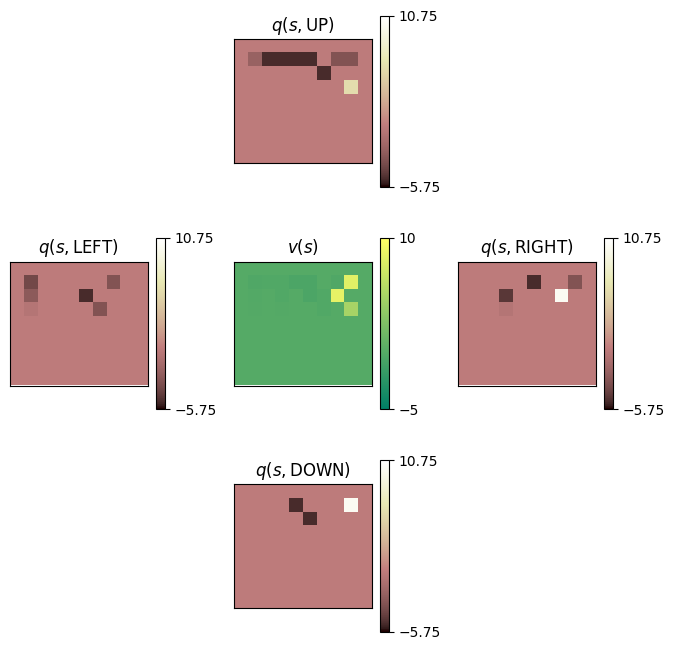

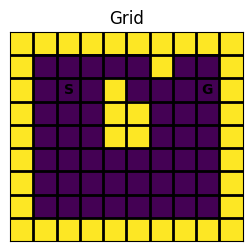

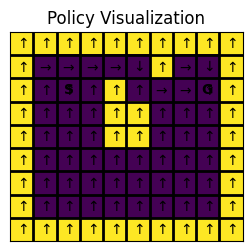

In [52]:
num_steps = 100000
epsilon=0.2

# environment
grid = Grid()

# agent
agent = QLearningAgent(
    number_of_states=grid._layout.size,
    actions=Action,
    initial_state=grid.get_obs(),
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps, epsilon)

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=epsilon)
grid.plot_grid()
visualise_policy(grid, agent)

### Tasks for both algorithms:
1. Plot the average reward as a function of the number of steps
2. Generate the above plot for different value of epsilon.
3. How different values of epsilon effect the training in both algorithms?
4. What is the optimal value for epsilon ?

In [53]:
def run_experiment_average(env, agent, number_of_steps, epsilon):
    mean_reward = 0
    action = agent.initialAction()
    # empty list - will add average rewards to it
    rewards = []

# average rewards - at each step
    for step in range(number_of_steps):
        reward, discount, next_state = env.step(action)
        action = agent.step(reward, discount, next_state, epsilon)
        mean_reward += (reward - mean_reward)/(step+1)
        # add all the average rewards for each step to a list
        rewards.append(mean_reward)
    
    
    return rewards

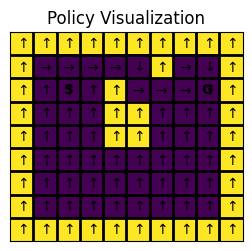

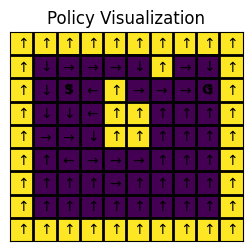

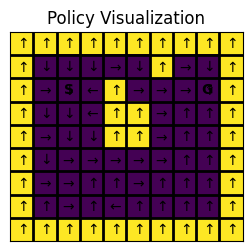

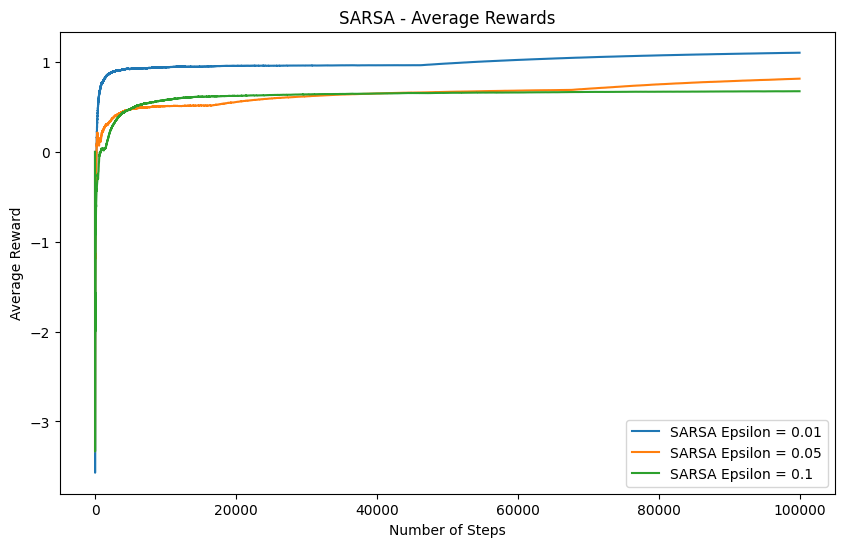

In [54]:
# SARSA
num_steps = 100000
#epsilons = [0.1, 0.5, 1]
epsilons = [0.01, 0.05, 0.1] #<--- for testing purposes 

# all the rewards for the specific epsilon will be added
epsilon_rewards = {}

# environment
for epsilon in epsilons:
    grid_S = Grid()

# agent
    agent_S = SarsaAgent(
        number_of_states=grid._layout.size,
        actions=Action,
        initial_state=grid.get_obs(),
        step_size=0.1)
    
    # get the rewards for the specific epsilon value
    epsilon_rewards[epsilon] = run_experiment_average(grid_S, agent_S, num_steps, epsilon)


# visualize value functions
    visualise_policy(grid_S, agent_S)

# plot the values
plt.figure(figsize=(10, 6))
# look at the value in the reward's list which is in the epsilon dictionary
for epsilon, rewards in epsilon_rewards.items():
    plt.plot(range(num_steps), rewards, label=f"SARSA Epsilon = {epsilon}")

plt.xlabel("Number of Steps")
plt.ylabel("Average Reward")
plt.title("SARSA - Average Rewards")
plt.legend()
plt.show()


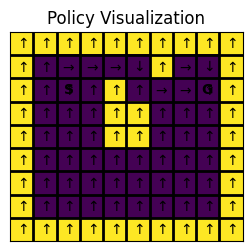

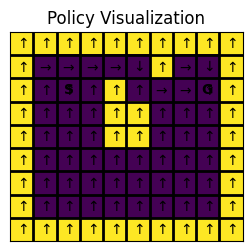

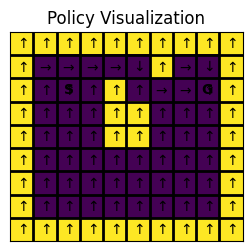

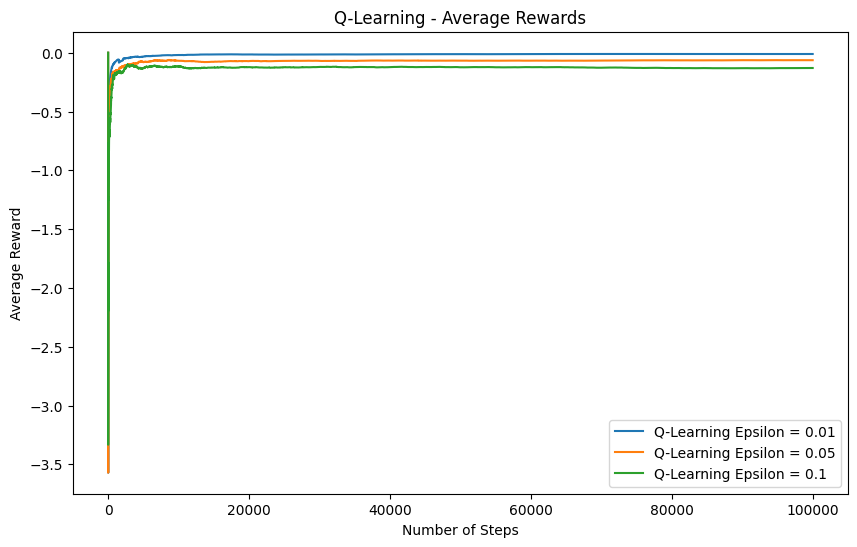

In [55]:
# Q-Learning
num_steps = 100000
#epsilons = [0.1, 0.5, 1]
epsilons = [0.01, 0.05, 0.1] #<--- for testing purposes

# all the rewards for the specific epsilon will be added
epsilon_rewards = {}

# environment
for epsilon in epsilons:
    grid_Q = Grid()

# agent
    agent_Q = QLearningAgent(
        number_of_states=grid._layout.size,
        actions=Action,
        initial_state=grid.get_obs(),
        step_size=0.1)
    
    # get the rewards for the specific epsilon value
    epsilon_rewards[epsilon] = run_experiment_average(grid_Q, agent_Q, num_steps, epsilon)

# visualize value functions
    visualise_policy(grid_Q, agent_Q)


plt.figure(figsize=(10, 6))
# look at the value in the reward's list which is in the epsilon dictionary
for epsilon, rewards in epsilon_rewards.items():
    plt.plot(range(num_steps), rewards, label=f"Q-Learning Epsilon = {epsilon}")

plt.xlabel("Number of Steps")
plt.ylabel("Average Reward")
plt.title("Q-Learning - Average Rewards")
plt.legend()
plt.show()